In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/ML/COVID_19_DATA/'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (126).png,0,COVID
1,COVID/Covid (178).png,0,COVID
2,COVID/Covid (1249).png,0,COVID
3,COVID/Covid (169).png,0,COVID
4,COVID/Covid (123).png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (281).png,0,COVID
1,COVID/Covid (64).png,0,COVID
2,non-COVID/Non-Covid (542).png,1,non-COVID
3,non-COVID/Non-Covid (608).png,1,non-COVID
4,COVID/Covid (749).png,0,COVID


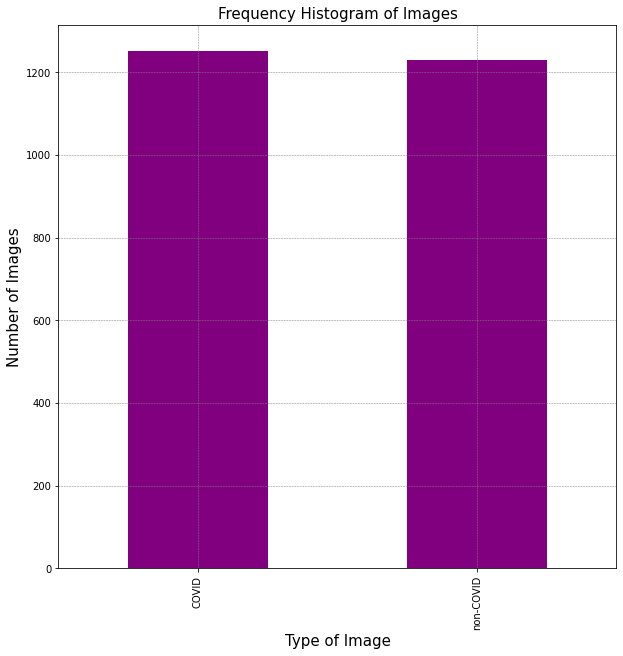

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import files as FILE
import os
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) 
train['Disease Type'].value_counts().plot(kind = "bar", color='purple')
plt.title('Frequency Histogram of Images', fontsize= 15)
plt.xlabel('Type of Image', fontsize=15)
plt.ylabel('Number of Images', fontsize=15)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()
plt.gcf()
plt.savefig('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/1.png',  dpi=300)

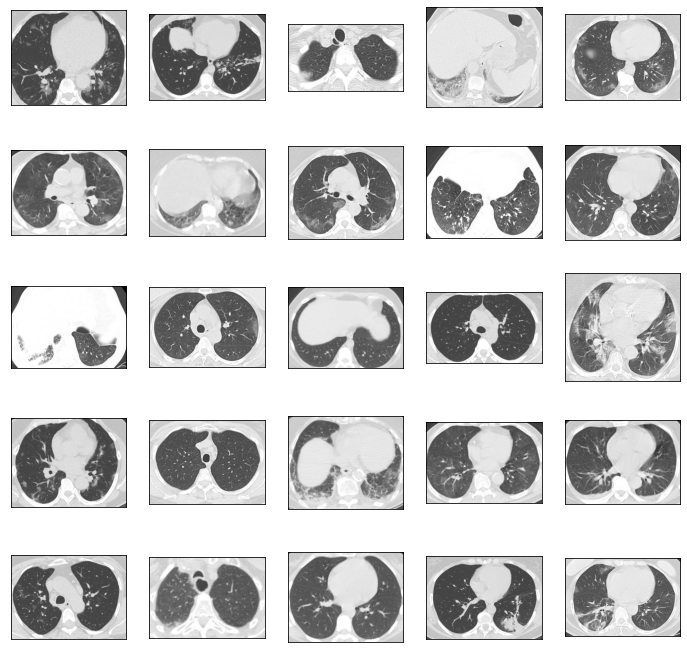

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

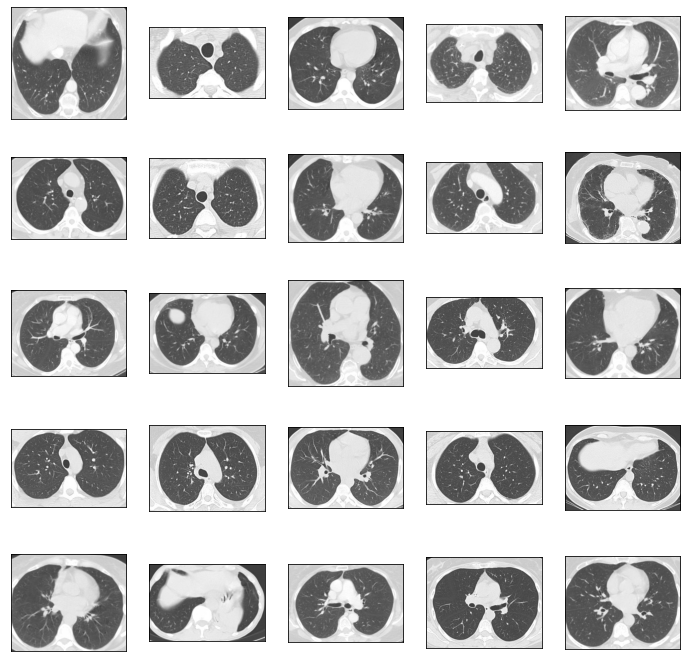

In [ ]:
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

In [ ]:
IMAGE_SIZE = 120
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [13:01,  3.17it/s]


Train Shape: (2481, 120, 120, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
BATCH_SIZE = 256

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

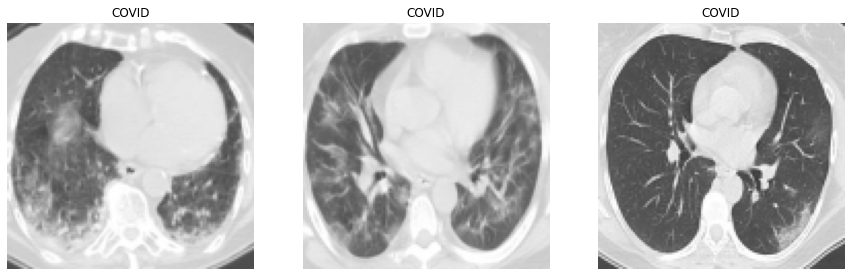

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 800
SIZE=120
N_ch=3

In [ ]:
def build_in():
    inception = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = inception(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_in()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/ResNet50_V3.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 3)       84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/800

Epoch 00001: val_loss improved from inf to 0.68701, saving model to /content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/ResNet50_V3.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


7/7 - 25s - loss: 1.3013 - accuracy: 0.5139 - val_loss: 0.6870 - val_accuracy: 0.5513 - lr: 0.0010 - 25s/epoch - 4s/step
Epoch 2/800

Epoch 00002: val_loss did not improve from 0.68701
7/7 - 6s - loss: 1.3181 - accuracy: 0.4919 - val_loss: 0.6911 - val_accuracy: 0.5915 - lr: 0.0010 - 6s/epoch - 805ms/step
Epoch 3/800

Epoch 00003: val_loss did not improve from 0.68701
7/7 - 6s - loss: 1.2864 - accuracy: 0.4884 - val_loss: 0.6885 - val_accuracy: 0.5493 - lr: 0.0010 - 6s/epoch - 851ms/step
Epoch 4/800

Epoch 00004: val_loss did not improve from 0.68701
7/7 - 6s - loss: 1.2245 - accuracy: 0.5087 - val_loss: 0.6989 - val_accuracy: 0.5513 - lr: 0.0010 - 6s/epoch - 852ms/step
Epoch 5/800

Epoch 00005: val_loss did not improve from 0.68701
7/7 - 6s - loss: 1.2610 - accuracy: 0.5012 - val_loss: 0.6979 - val_accuracy: 0.5513 - lr: 0.0010 - 6s/epoch - 789ms/step
Epoch 6/800

Epoch 00006: val_loss did not improve from 0.68701
7/7 - 6s - loss: 1.2728 - accuracy: 0.5081 - val_loss: 0.6902 - val_acc

In [ ]:
model = load_model('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/ResNet50_V3.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 26ms/step - loss: 0.0516 - accuracy: 0.9819
Final Loss: 0.051614150404930115, Final Accuracy: 0.9818913340568542


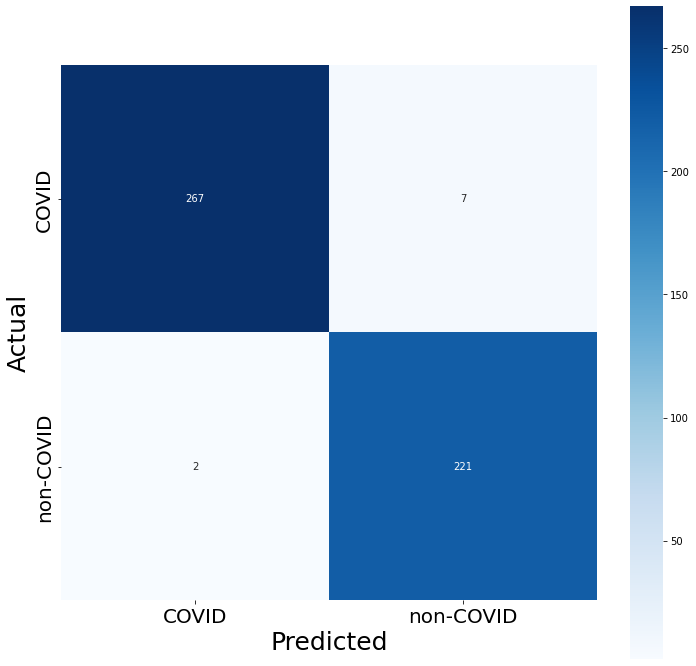

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='g', square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=25)
ax.set_xlabel('Predicted', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/2.png' , dpi=300)

In [ ]:


TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP)
print(TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

0.9910313901345291
0.9744525547445255
0.008968609865470852
0.9818913480885312


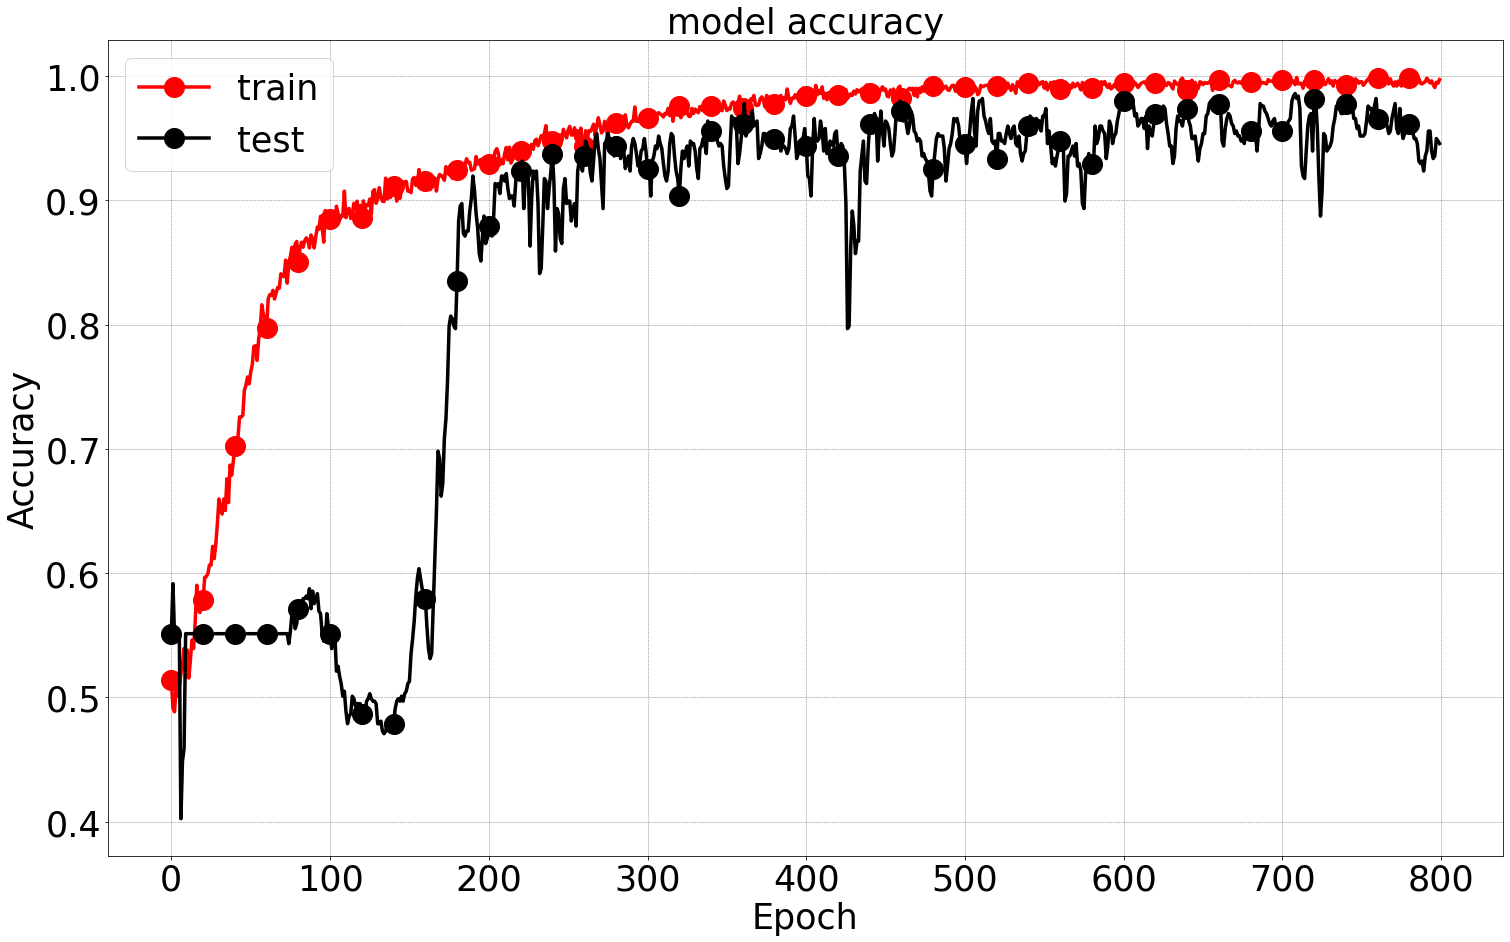

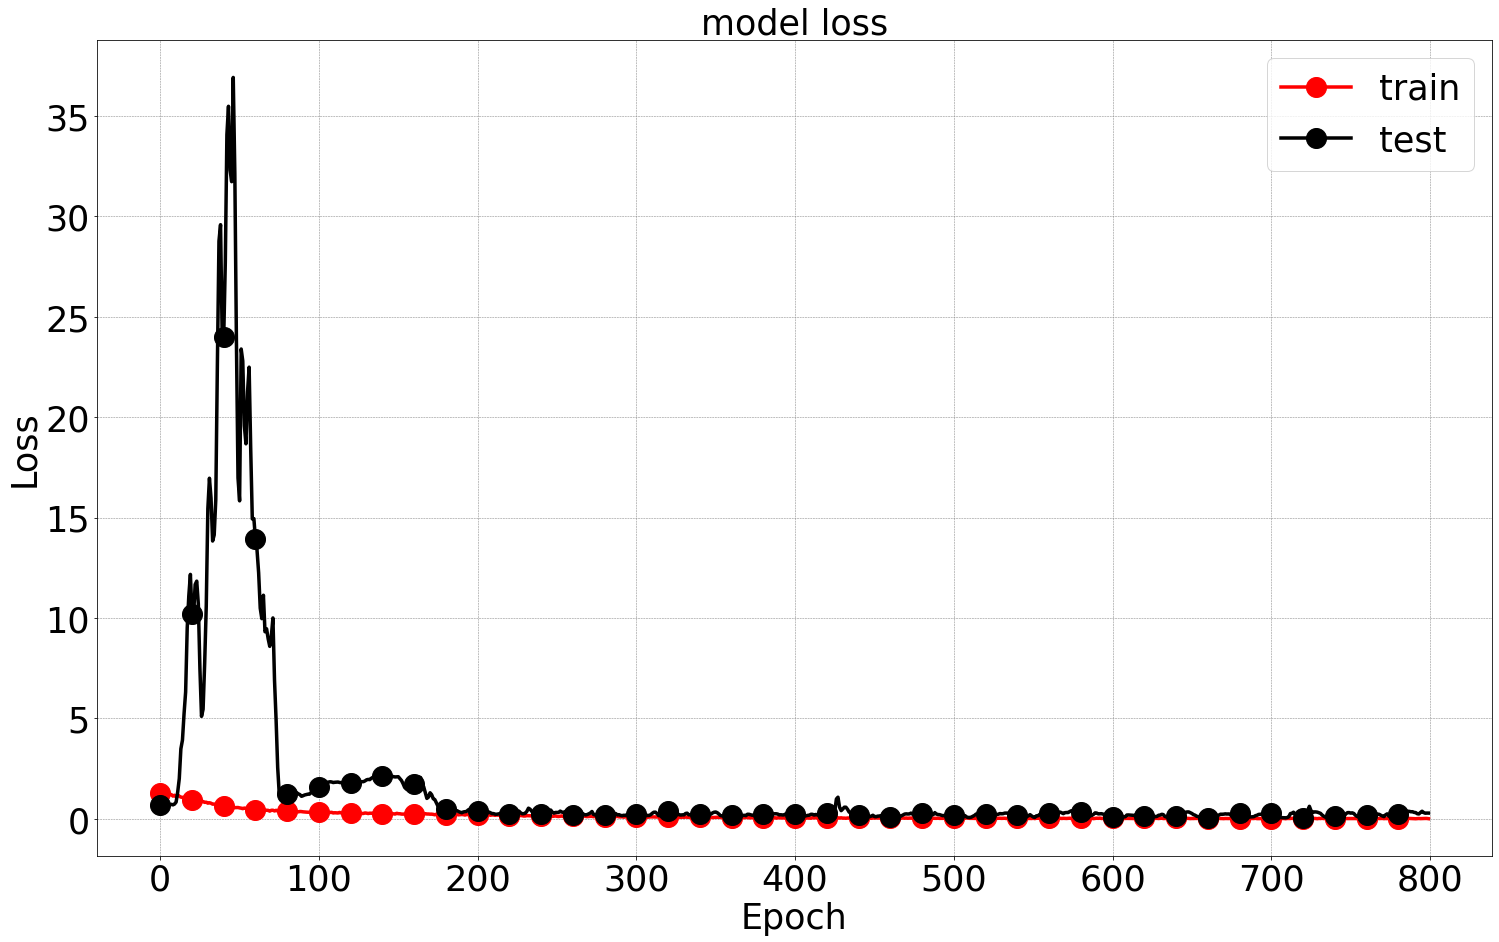

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'], color='red', marker = 'o', markevery=20, ms = 20, linewidth = '3.5')
plt.plot(hist.history['val_accuracy'], color='black',marker = 'o', markevery=20, ms = 20, linewidth = '3.5')
plt.title('model accuracy', fontsize=35)
plt.ylabel('Accuracy', fontsize=35)
plt.xlabel('Epoch', fontsize=35)
plt.legend(['train', 'test'], loc='upper left', fontsize=35 )
plt.cm.get_cmap('tab10', 2)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.rcParams["figure.figsize"] = (25,15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.savefig('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/3.png', dpi=300)


plt.show()



# accuracy plot 
plt.plot(hist.history['loss'], color='red', marker = 'o', markevery=20, ms = 20, linewidth = '3.5')
plt.plot(hist.history['val_loss'], color='black',marker = 'o', markevery=20, ms = 20, linewidth = '3.5')
plt.title('model loss', fontsize=35)
plt.ylabel('Loss', fontsize=35)
plt.xlabel('Epoch', fontsize=35)
plt.legend(['train', 'test'], loc='upper right', fontsize=35 )
plt.cm.get_cmap('tab10', 2)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.rcParams["figure.figsize"] = (25,15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.savefig('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/4.png',  dpi=300)

[9.9973279e-01 2.6721516e-04]


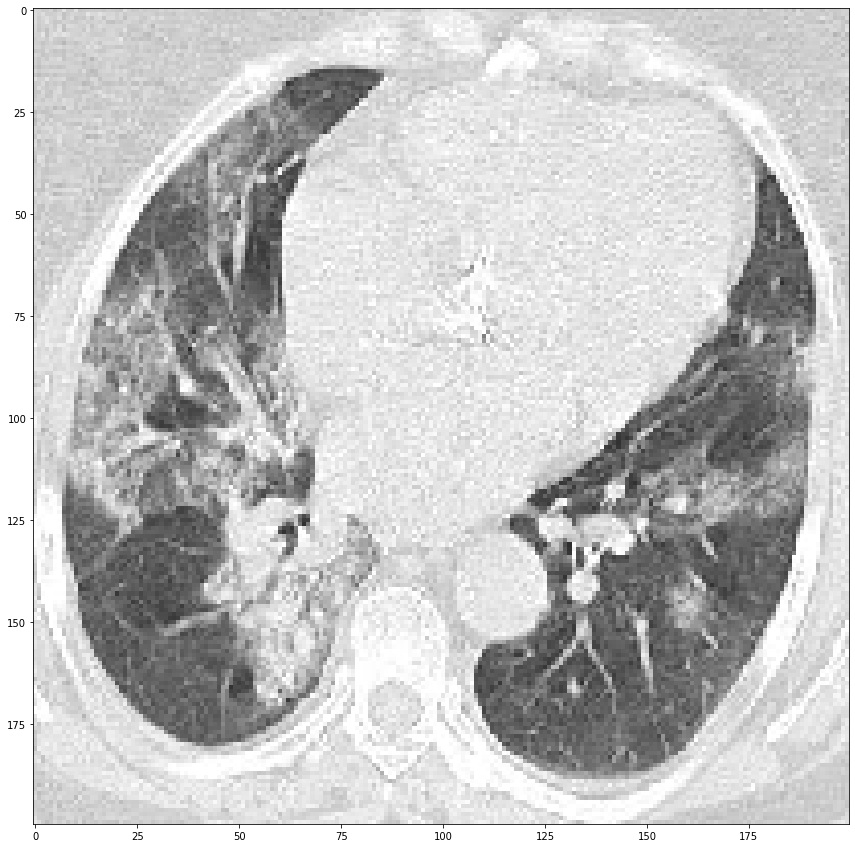

Prediction: Covid-19


In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/ML/COVID_19_DATA/COVID/Covid (1010).png', grayscale=False, target_size=(120, 120))
show_img=image.load_img('/content/drive/MyDrive/ML/COVID_19_DATA/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

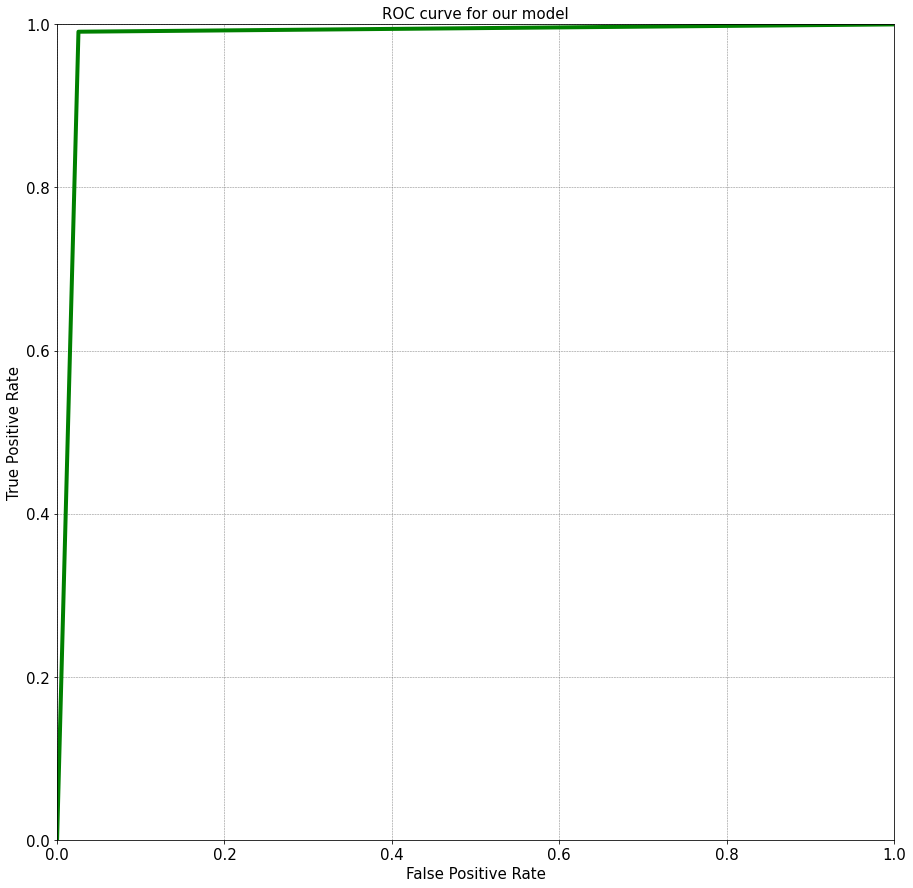

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred)
plt.figure(figsize=(15, 15))
plt.plot(fpr, tpr, color='green', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for our model', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.savefig('/content/drive/MyDrive/ML/COVID_19_DATA/Images/ResNet50_V3/5.png',  dpi=300)